In [189]:
import numpy as np
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Masking, Bidirectional, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [27]:
def plotTSNE(tsne_results, Y_test):
    plt.figure(figsize=(12,12))
    label = Y_test
    colors = ['blue', 'red']
    plt.scatter(x=tsne_results[:,0], y=tsne_results[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors), s=3)

In [2]:
X = np.asarray(pd.read_csv("data/diabetes/X_enc.csv", header=None))
X_val = np.asarray(pd.read_csv("data/diabetes/X_val_enc.csv", header=None))
X_test = np.asarray(pd.read_csv("data/diabetes/X_test_enc.csv", header=None))
Y = np.asarray(pd.read_csv("data/diabetes/Y.csv", header=None)).reshape(-1).astype(int)
Y_val = np.asarray(pd.read_csv("data/diabetes/Y_val.csv", header=None)).reshape(-1).astype(int)
Y_test = np.asarray(pd.read_csv("data/diabetes/Y_test.csv", header=None)).reshape(-1).astype(int)
header = pd.read_csv("data/diabetes/diab_train.csv").keys()

In [3]:
print(header)

Index(['Unnamed: 0', 'race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_desc', 'diag_2_desc', 'diag_3_desc'],
      dtype='object')


In [5]:
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X2, y=Y2)

In [43]:
X_discharge_disposition = pickle.load(open("data/diabetes/X_discharge_disposition_enc.csv", "rb"))
X_val_discharge_disposition = pickle.load(open("data/diabetes/X_val_discharge_disposition_enc.csv", "rb"))
X_test_discharge_disposition = pickle.load(open("data/diabetes/X_test_discharge_disposition_enc.csv", "rb"))

In [44]:
print(X_discharge_disposition.shape)

(6000, 3)


In [45]:
X_diagnoses_pca = pickle.load(open("data/diabetes/X_diagnoses_pca.csv", "rb")).reshape(6000, -1)
X_val_diagnoses_pca = pickle.load(open("data/diabetes/X_val_diagnoses_pca.csv", "rb")).reshape(2000, -1)
X_test_diagnoses_pca = pickle.load(open("data/diabetes/X_test_diagnoses_pca.csv", "rb")).reshape(2000, -1)

In [46]:
X_diagnoses_lda = pickle.load(open("data/diabetes/X_diagnoses_lda.csv", "rb")).reshape(6000, -1)
X_val_diagnoses_lda = pickle.load(open("data/diabetes/X_val_diagnoses_lda.csv", "rb")).reshape(2000, -1)
X_test_diagnoses_lda = pickle.load(open("data/diabetes/X_test_diagnoses_lda.csv", "rb")).reshape(2000, -1)

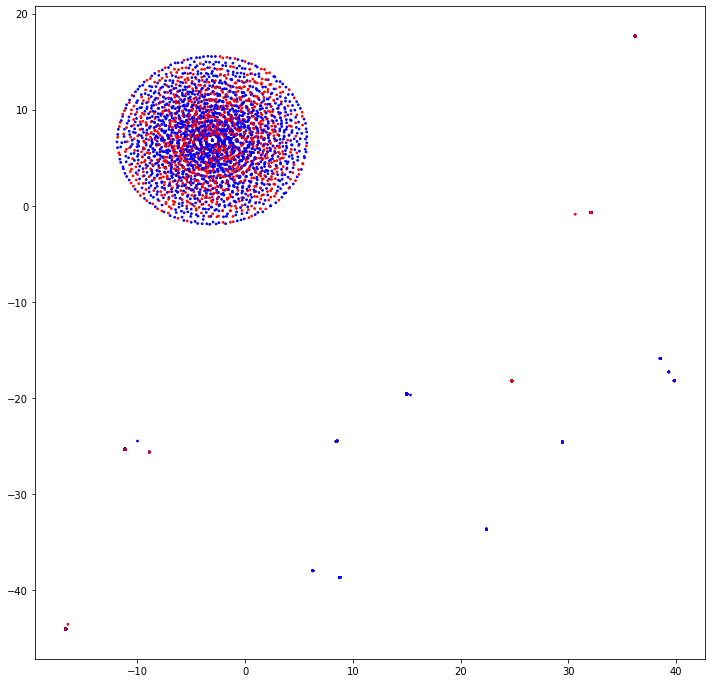

In [47]:
plotTSNE(TSNE().fit_transform(X_discharge_disposition), Y)

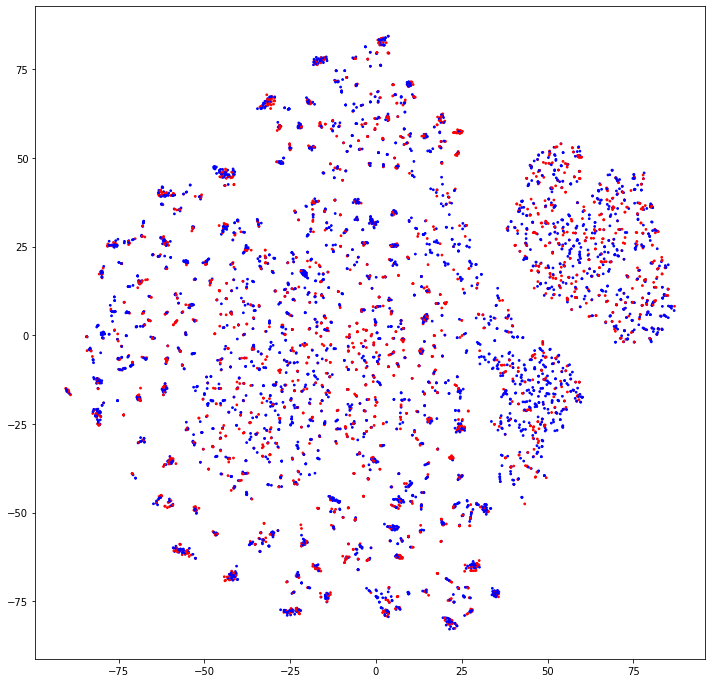

In [49]:
plotTSNE(TSNE().fit_transform(np.hstack([X, X_diagnoses_lda, X_discharge_disposition])), Y)

In [73]:
X_comb = np.hstack([X, X_diagnoses_lda, X_discharge_disposition])
X_val_comb = np.hstack([X_val, X_val_diagnoses_lda, X_val_discharge_disposition])
X_test_comb = np.hstack([X_test, X_test_diagnoses_lda, X_test_discharge_disposition])

In [191]:
X2 = np.vstack([X_comb, X_val_comb])
Y2 = np.hstack([Y, Y_val])

In [171]:
def model():
    x = Input(shape=(65,))
    x_d = Input(shape=(10, 3174))
    x_dis = Input(shape=(4, 44))
    
    rnn_d = LSTM(30)(x_d)
    rnn_dis = LSTM(20)(x_dis)
    
    conc = Concatenate()([x, rnn_d, rnn_dis])

    dense = Dense(400, activation='relu', name="dense")(x)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(300, activation='relu', name="dense2")(dense)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(200, activation='relu', name="dense3")(dense)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    dense = Dense(100, activation='relu', name="dense4")(dense)
    dense = Dropout(.1)(dense)
    dense = BatchNormalization()(dense)
    y = Dense(1, activation='sigmoid', name="y")(dense)

    model = models.Model([x, x_d, x_dis], y, name="model")
    model.compile(optimizer='Adam', loss="binary_crossentropy", metrics=['acc'])

    return model

In [172]:
m = model()

In [173]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 400)          26400       input_12[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 400)          0           dense[0][0]                      
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 400)          1600        dropout_12[0][0]                 
______________________________________________________________________________________________

In [174]:
Y.shape

(6000,)

In [175]:
cbs = []
cbs.append(EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1))
cbs.append(ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2))        
m.fit([X, X_diagnoses, X_discharge_disposition], Y, shuffle=True, epochs=100, \
      validation_data=([X_val], Y_val), \
      callbacks=cbs)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 1 arrays: [array([[0.03523807, 0.        , 0.08222217, ..., 0.        , 0.        ,
        0.        ],
       [0.03279521, 0.        , 0.05465868, ..., 0.        , 0.        ,
        0.        ],
       [0.0...

In [16]:
f1_score(Y_val, m.predict(X_val).round().astype(int))

0.4016326530612245

In [45]:
print(m.predict(X_val).round().astype(int).reshape(-1)[:30])
print(Y_val.astype(int).reshape(-1)[:30])

[0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1]
[0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1]


In [302]:
import lightgbm as lgbm
param_grid = {
    'boosting_type': ['gbdt'],
    'num_leaves': [18],
    'reg_alpha': [0.824],
    'min_data_in_leaf': [110],
    'max_bin': [258],
    'feature_fraction': [0.458],
    'bagging_fraction': [0.00000000000000005, 0.0000000001]
    }

lgb_estimator = lgbm.LGBMClassifier(objective='binary', 
                                    class_weight='balanced',
                                    eval_metric='f1',
                                    jobs=-1)
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_comb, y=Y)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf, verbose=3, n_jobs=-1, scoring='f1')

In [303]:
lgb_model = gsearch.fit(X=X_comb, y=Y)
print(lgb_model.best_params_, lgb_model.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s


{'bagging_fraction': 5e-17, 'boosting_type': 'gbdt', 'feature_fraction': 0.458, 'max_bin': 258, 'min_data_in_leaf': 110, 'num_leaves': 18, 'reg_alpha': 0.824} 0.5674922689939461


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [450]:
lgb_estimator = lgbm.LGBMClassifier(boosting_type='gbdt', \
                                    lambda_l1=1, \
                                    lambda_l2=0, \
                                    min_data_in_leaf=110, \
                                    num_leaves=18, 
                                    max_bin=258, \
                                    objective='binary', \
                                    class_weight='balanced',
                                    feature_fraction=.6,
                                    num_boost_round=1000
                                   )
lgb_estimator.fit(X_comb,
                  Y,
                  eval_set=(X_val_comb, Y_val), 
                  early_stopping_rounds=5, 
                  eval_metric='f1', verbose=0, 
                  callbacks = [lgbm.reset_parameter(learning_rate = np.linspace(0.12, 0.05, 20).tolist()+[0.05]*980)])

/home/vescovo/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', lambda_l1=1, lambda_l2=0,
               learning_rate=0.1, max_bin=258, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=110, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1000, num_leaves=18,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [451]:
print(f1_score(Y_test, lgb_estimator.predict(X_test_comb).round().astype(int)))
print(lgb_estimator.predict(X_test_comb)[:30])
print((np.round(np.max(lgb_estimator.predict_proba(X_test_comb)[:30], axis=1), 1)*10).astype(int))
print(Y_test[:30])

0.5929411764705882
[1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1]
[6 5 7 5 6 6 6 7 5 6 6 5 5 7 5 6 7 6 6 5 6 5 6 6 6 6 5 7 7 6]
[0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0]


In [100]:
np.asarray(list(zip(np.sort(lgb_estimator.feature_importances_), np.argsort(lgb_estimator.feature_importances_))))[-60:]

array([[ 4, 90],
       [ 5, 60],
       [ 5, 78],
       [ 5, 48],
       [ 5, 21],
       [ 5, 94],
       [ 6, 66],
       [ 6, 72],
       [ 7, 88],
       [ 7, 92],
       [ 8, 86],
       [ 8, 76],
       [ 8, 22],
       [ 9, 68],
       [ 9, 91],
       [10, 81],
       [10, 75],
       [10, 45],
       [11, 80],
       [11, 87],
       [14, 65],
       [15, 89],
       [15, 93],
       [15,  7],
       [15, 69],
       [17, 96],
       [17, 24],
       [17, 85],
       [17, 13],
       [18, 79],
       [18, 44],
       [18, 82],
       [18, 73],
       [20, 14],
       [20, 38],
       [22, 74],
       [22, 39],
       [22,  1],
       [23,  3],
       [24, 84],
       [25, 10],
       [26, 70],
       [26, 62],
       [26,  5],
       [29, 83],
       [33, 32],
       [33, 71],
       [35, 77],
       [36,  6],
       [36,  9],
       [38,  2],
       [39, 54],
       [39, 42],
       [42, 97],
       [46,  4],
       [46, 95],
       [52,  0],
       [65, 12],
       [66,  8

In [453]:
from sklearn.svm import SVC

In [463]:
param_grid = {
    'C': [3.5, 4, 6, 10],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    #'degree': [2, 3, 4, 5],
    'gamma': ['auto', 'scale'],
    'shrinking': [True, False],
    'decision_function_shape': ['ovo', 'ovr']
    }

clf = SVC(class_weight='balanced')

gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_comb, y=Y)
gsearch_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=gkf, verbose=3, n_jobs=-1, scoring='f1')

In [464]:
clf_model = gsearch_clf.fit(X=X_comb, y=Y)
print(clf_model.best_params_, clf_model.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 12.0min finished


{'C': 4, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear', 'shrinking': True} 0.5523569916621718


In [461]:
clf = SVC(class_weight='balanced', C=2, kernel='linear', degree=2, gamma='auto', shrinking=True, decision_function_shape='ovo')
clf.fit(X, Y.reshape(-1).astype(int))

SVC(C=2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=2, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [462]:
f1_score(Y_val, clf.predict(X_val).round().astype(int))

0.5481400437636762

In [1]:
from sklearn.ensemble import AdaBoostClassifier

In [35]:
param_grid = {
    'C': [0.1, 0.5, 1, 2],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['auto', 'scale'],
    'shrinking': [True, False],
    'decision_function_shape': ['ovo', 'ovr']
    }

ada = AdaBoostClassifier(n_estimators=1000, random_state=0)

gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_comb, y=Y)
gsearch_ada = GridSearchCV(estimator=ada, param_grid=param_grid, cv=gkf, verbose=3, n_jobs=-1, scoring='f1')

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=1000, random_state=0)

In [ ]:
ada_model = gsearch_ada.fit(X=X_comb, y=Y)
print(ada_model.best_params_, ada_model.best_score_)

In [ ]:
ada = AdaBoostClassifier(n_estimators=1000, random_state=0)
ada.fit(X, Y)

In [36]:
f1_score(Y_val, ada.predict(X_val))

0.4201930215293245

In [467]:
from sklearn.linear_model import SGDClassifier

In [468]:
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 
             'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.00001, 0.0001, 0.001],
    'l1_ratio': [0, 0.15, 0.3],
    'early_stopping': [True, False],
    'validation_fraction': [.2]
    }

sgd = SGDClassifier()

gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X2, y=Y2)
gsearch_sgd = GridSearchCV(estimator=sgd, param_grid=param_grid, cv=gkf, verbose=3, n_jobs=-1, scoring='f1')

In [ ]:
sgd_model = gsearch_sgd.fit(X=X2, y=Y2)
print(sgd_model.best_params_, sgd_model.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   15.7s


In [108]:
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
sgd.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [109]:
f1_score(Y_val, sgd.predict(X_val))

0.010012515644555695

In [110]:
f1_score(Y_test, sgd.predict(X_test))

0.007537688442211054

In [45]:
sgd.predict(X_val).sum()

874

In [112]:
from sklearn.neighbors import KNeighborsClassifier

In [174]:
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'early_stopping': [True, False],
    'validation_fraction': [.2]
    }

knn = KNeighborsClassifier(4, weights='distance')

gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_comb, y=Y)
gsearch_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=gkf, verbose=3, n_jobs=-1, scoring='f1')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
knn_model = gsearch_knn.fit(X=X_comb, y=Y)
print(knn_model.best_params_, knn_model.best_score_)

In [ ]:
knn = KNeighborsClassifier(4, weights='distance')
knn.fit(X, Y)

In [175]:
f1_score(Y_val, knn.predict(X_val))

0.42946490618485056

In [177]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [179]:
kernel = 1.0 * RBF(1.0)

In [183]:
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X, Y)

In [185]:
f1_score(Y_val, gpc.predict(X_val))

0.37823834196891193

In [186]:
from sklearn import tree

In [187]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X, Y)

In [188]:
f1_score(Y_val, dt.predict(X_val))

0.4616360177552315